## EEG Information

1. Loading Data
    - Load csv
2. Arfitact Removal
    - transform pandas to raw mne
    - Remove Power Line Noise (50Hz, 100Hz, 150Hz, 200Hz, 250Hz)
    - Band Pass: 1 - 20 Hz

3. ICA

4. Epoching  
- tmin = -0.2
- tmax= 0.8
- events = {" non-target " : 1, " target " : 2}

In [1]:
# import library
import pandas as pd
import numpy as np
import mne
from mne import create_info
from mne.io import RawArray
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Loading Data

#### Load CSV

In [2]:
#Prepare Data 
df = pd.read_csv('group_01.csv', delimiter = ',', dtype = 'float64')
header_data = pd.read_csv('Header.csv', delimiter = ',')

#Add header to dataset
df.columns = list(header_data)
df.head()

,Time,FP1_1,FP2_1,AFZ_1,F7_1,F3_1,F4_1,F8_1,FC5_1,FC1_1,...,P8_2,PO7_2,O1_2,Oz_2,O2_2,PO8_2,PO9_2,PO10_2,Events,Target
0,0.001953,54589.0,55238.0,68817.0,61389.0,60659.0,59589.0,50781.0,58104.0,68243.0,...,24600.0,26544.0,27900.0,23125.0,20075.0,-2081.4,19024.0,-132130.0,0.0,0.0
1,0.003906,54646.0,55321.0,68880.0,61461.0,60742.0,59674.0,50868.0,58182.0,68316.0,...,24598.0,26539.0,27900.0,23126.0,20071.0,-2084.6,19019.0,-132070.0,0.0,0.0
2,0.005859,54790.0,55508.0,69034.0,61630.0,60919.0,59860.0,51062.0,58351.0,68481.0,...,24631.0,26579.0,27924.0,23162.0,20089.0,-2063.2,19067.0,-132370.0,0.0,0.0
3,0.007812,54862.0,55602.0,69114.0,61722.0,61011.0,59951.0,51157.0,58438.0,68571.0,...,24639.0,26580.0,27927.0,23151.0,20104.0,-2047.4,19069.0,-132540.0,0.0,0.0
4,0.009766,54959.0,55724.0,69222.0,61831.0,61129.0,60073.0,51279.0,58551.0,68685.0,...,24667.0,26603.0,27963.0,23175.0,20138.0,-2018.4,19098.0,-133000.0,0.0,0.0


In [3]:
df = df.drop(['Time'], axis = 1) # Drop Time column
#print(group1.columns)


#Prepare standard 10-20 systems with 32 electrodes
# chennels named according to the experiment
header = ['Fp1', 'Fp2', 'AFz', 'F7', 'F3', 'F4', 'F8', 
          'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 
          'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 
          'P3', 'Pz', 'P4', 'P8', 'PO7', 'O1', 'Oz', 
          'O2', 'PO8', 'PO9', 'PO10','Target']

In [4]:
#For Subject1

df_s1 = df.iloc[:, :32]  # Slicing data for subject1
df_s1['Target'] = df['Target'] # Add Target column
df_s1.columns = header # Add column names
df_s1.head()

,Fp1,Fp2,AFz,F7,F3,F4,F8,FC5,FC1,FC2,...,P4,P8,PO7,O1,Oz,O2,PO8,PO9,PO10,Target
0,54589.0,55238.0,68817.0,61389.0,60659.0,59589.0,50781.0,58104.0,68243.0,70366.0,...,49613.0,53932.0,57899.0,57379.0,54521.0,54029.0,55296.0,53193.0,50795.0,0.0
1,54646.0,55321.0,68880.0,61461.0,60742.0,59674.0,50868.0,58182.0,68316.0,70435.0,...,49705.0,54017.0,57997.0,57480.0,54617.0,54125.0,55391.0,53275.0,50886.0,0.0
2,54790.0,55508.0,69034.0,61630.0,60919.0,59860.0,51062.0,58351.0,68481.0,70597.0,...,49895.0,54200.0,58188.0,57672.0,54790.0,54303.0,55582.0,53470.0,51077.0,0.0
3,54862.0,55602.0,69114.0,61722.0,61011.0,59951.0,51157.0,58438.0,68571.0,70681.0,...,49979.0,54284.0,58260.0,57744.0,54860.0,54377.0,55666.0,53550.0,51164.0,0.0
4,54959.0,55724.0,69222.0,61831.0,61129.0,60073.0,51279.0,58551.0,68685.0,70793.0,...,50103.0,54404.0,58378.0,57868.0,54985.0,54499.0,55787.0,53676.0,51282.0,0.0


## 2. Artifact Removal

In [5]:
#transform pandas to mne type
def df_to_raw(df):
    
    sfreq = 512  # according to the experiment
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim'] 
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
    df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #try plotting the raw data of its power spectral density
    raw.plot()
    raw.plot_psd()

    return raw

_______________________RawArray for Subject1______________________
Creating RawArray with float64 data, n_channels=33, n_times=454431
    Range : 0 ... 454430 =      0.000 ...   887.559 secs
Ready.
Using matplotlib as 2D backend.


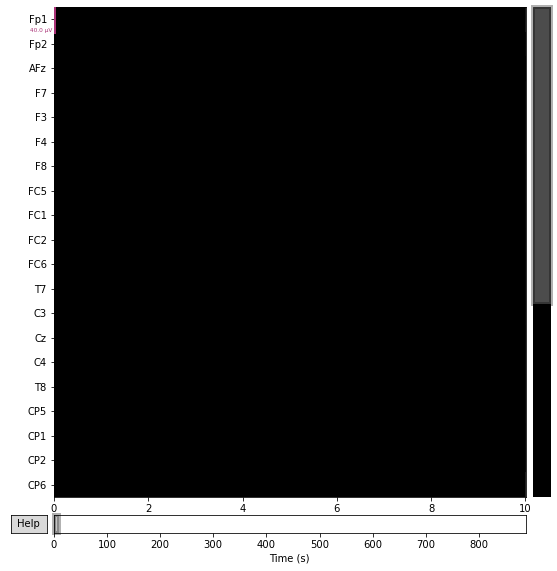

Effective window size : 4.000 (s)


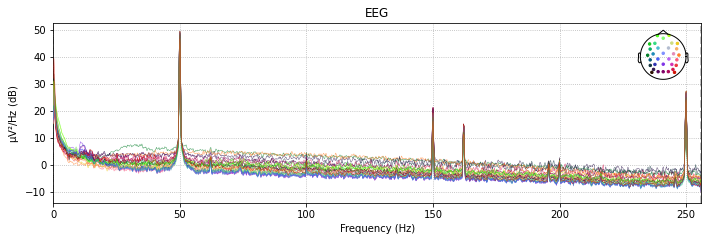

In [6]:
print("_______________________RawArray for Subject1______________________")
raw_s1 = df_to_raw(df_s1)

#### 1. Power Line noise

Remove the 50Hz power line noise and we will also remove its harmonics, i.e., 100Hz, 150Hz etc. Since our signal is 260Hz (520Hz / 2 according to Nyquist Theorem), we shall run the harmonics until 260 Hz.

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)

Effective window size : 4.000 (s)


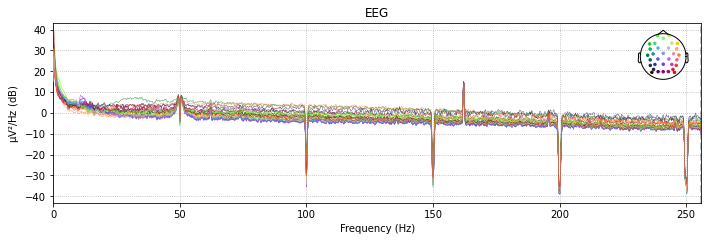

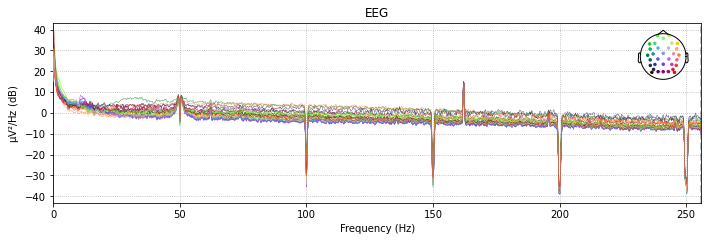

In [7]:
raw_s1.notch_filter(np.arange(50, 260, 50), filter_length='auto', phase='zero') # 520 / 2
raw_s1.plot_psd()

#### 2. Slow drift

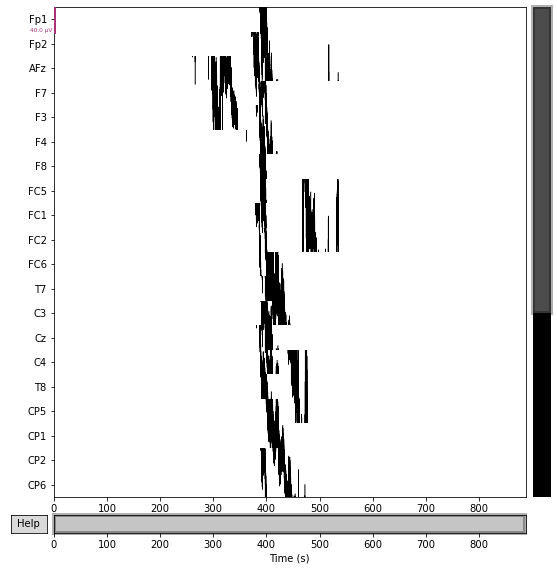

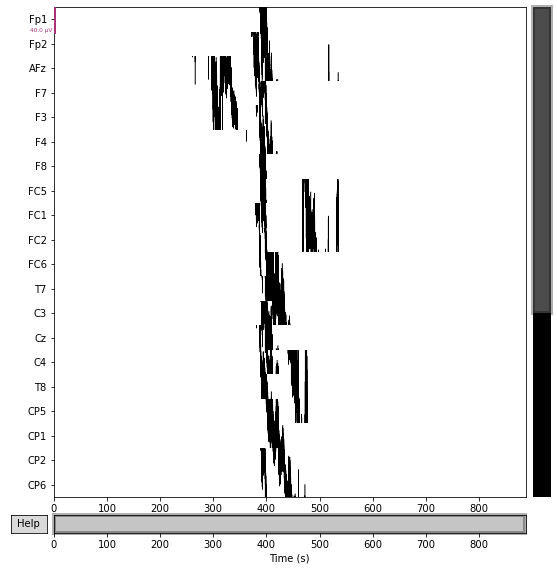

In [8]:
eeg_channels = mne.pick_types(raw_s1.info, eeg=True)
raw_s1.plot(duration=1200, order=eeg_channels) # the duration for one session is around five minutes, so 20mins(1200s) for four sessions

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 16897 samples (33.002 sec)



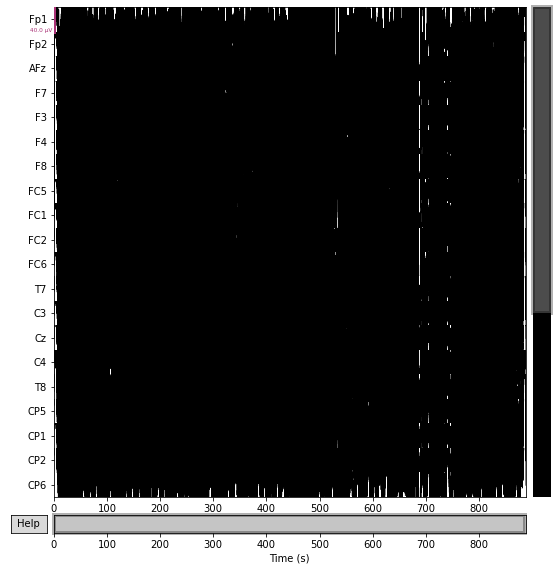

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 8449 samples (16.502 sec)



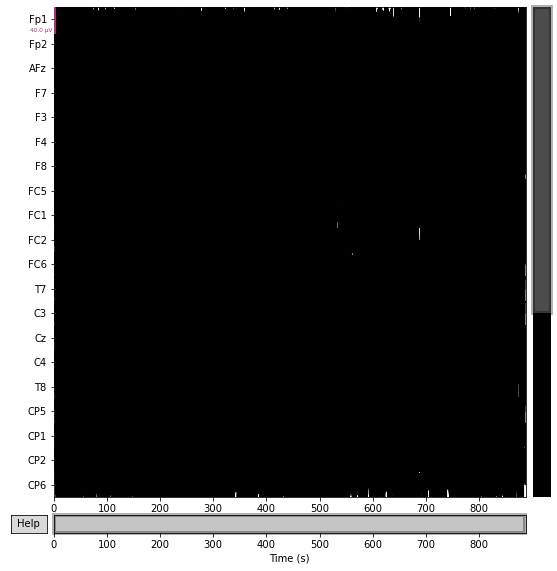

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)



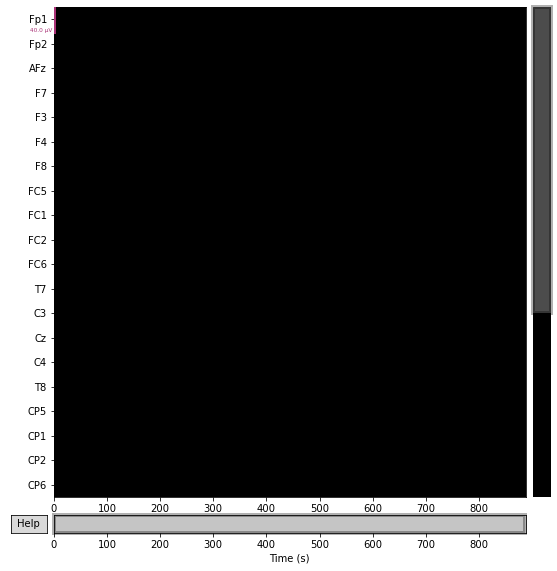

In [9]:
for cutoff in (0.1, 0.2, 1):
    raw_highpass = raw_s1.copy().filter(l_freq=cutoff, h_freq=None)
    fig = raw_highpass.plot(duration=1200, order=eeg_channels)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('High-pass filtered at {} Hz'.format(cutoff), size='xx-large',
                 weight='bold')

Looks like 0.2Hz was quite quite good to fully remove the slow drifts. Usually, 0.2Hz is a good measure since most of the brain frequency lies around 0.2 to 40Hz. We shall filter our brain signal to 1 - 15 Hz according to the paper https://hal.inria.fr/hal-00756669/document

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Effective window size : 4.000 (s)


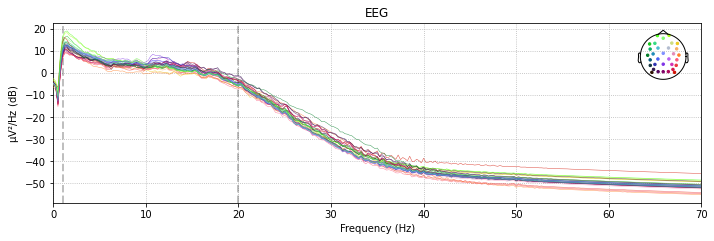

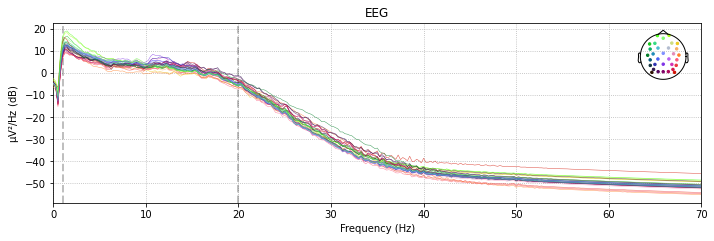

In [10]:
raw_s1.filter(1,20, method = 'iir')
raw_s1.plot_psd(fmax = 70)

#### EEG Artifacts

The types of artifacts that contaminate EEG data
 - blinks
 - muscle movements
 - brief amplifier saturations
 - line noise

### 3. Independent component analysis

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Effective window size : 4.000 (s)


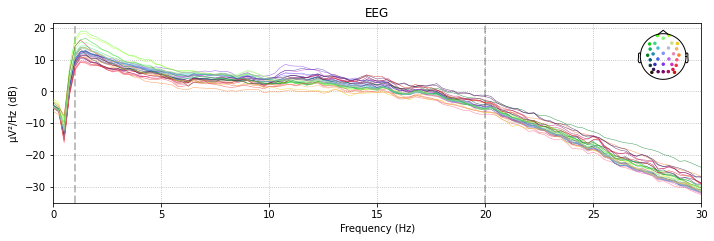

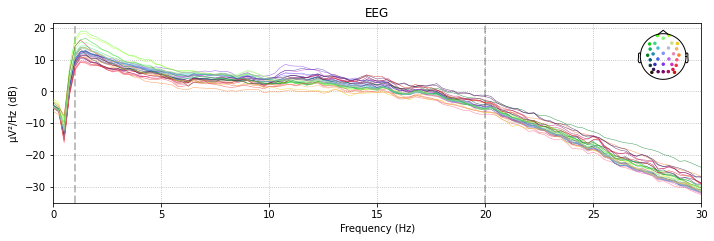

In [11]:
from mne.preprocessing import ICA

filt_raw = raw_s1.copy()
filt_raw.load_data().filter(l_freq=1.,h_freq=None)
filt_raw.plot_psd(fmax = 30)

In [12]:
ica = ICA(n_components = 32, random_state = 32)
ica.fit(filt_raw)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 37.3s.


Method,fastica
Fit,83 iterations on raw data (454431 samples)
ICA components,32
Explained variance,100.0 %
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=32, n_times=454431
    Range : 0 ... 454430 =      0.000 ...   887.559 secs
Ready.


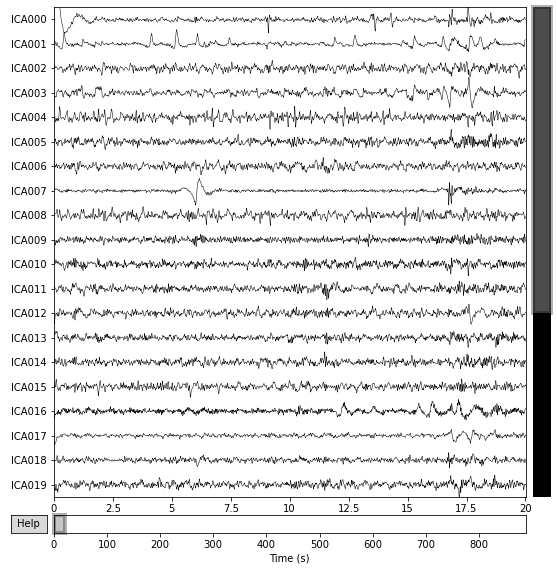

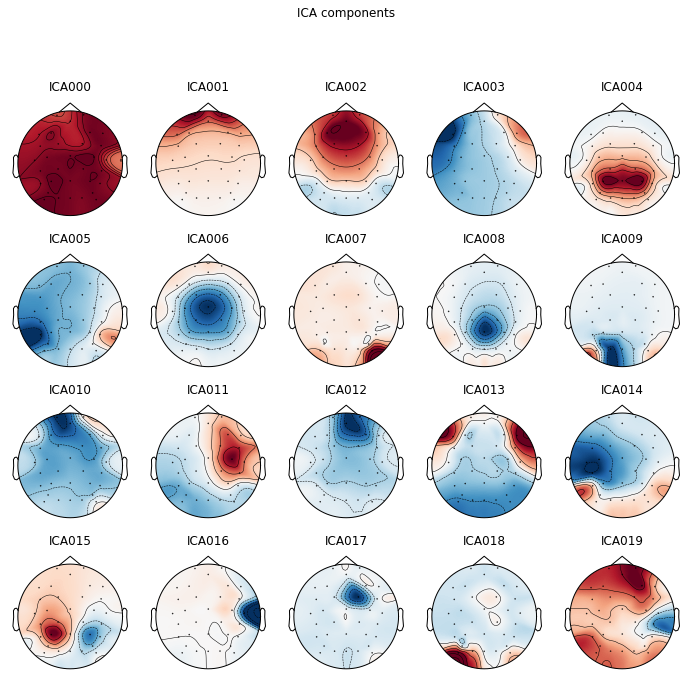

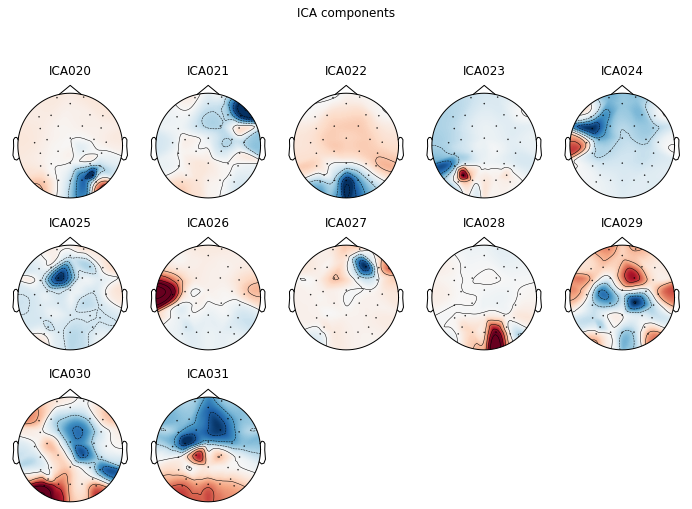

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x526.68 with 12 Axes>]

In [13]:
ica.plot_sources(filt_raw)
ica.plot_components(res = 64)

In [14]:
# ica.plot_properties(filt_raw, picks = [0,1])

In [15]:
# ica.plot_overlay(filt_raw, exclude=[4,5], picks='eeg')

## 4. Epoching

In [16]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    
    #reject_criteria = dict(mag=4000e-15,     # 4000 fT
    #                       grad=4000e-13,    # 4000 fT/cm
    #                       eeg=100e-6,       # 150 μV
    #                       eog=250e-6)       # 250 μV

    reject_criteria = dict(eeg=100e-6)  #most voltage in this range is not brain components

    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [17]:
# ### https://www.sciencedirect.com/science/article/pii/S1746809410000558
event_id = {'Non-Target' : 1, "Target" : 2}
tmin = -0.1
tmax = 0.7
picks = eeg_channels
epochs = getEpochs(raw_s1, event_id, tmin, tmax, picks)

636 events found
Event IDs: [1 2]
sample drop %:  0.0


In [18]:
X = epochs.get_data()
y = epochs.events[:, -1]

print(X.shape)
print(y.shape)

(636, 32, 410)
(636,)


#### Plotting ERP of targets vs. non-targets

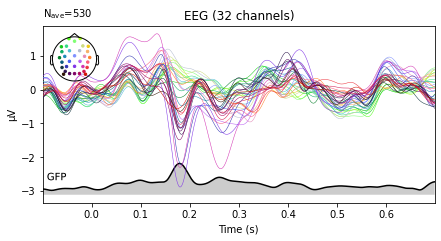

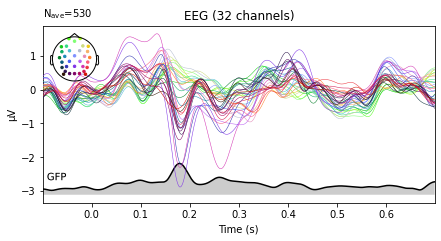

In [19]:
evoked_non = epochs['Non-Target'].average()
evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s')

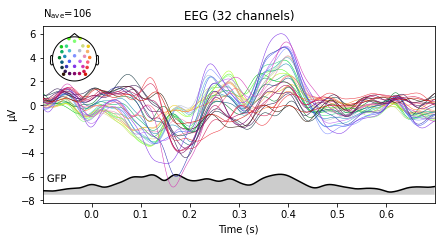

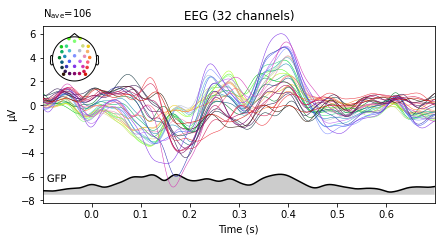

In [20]:
# evoked_non = epochs['Non-Target'].average()
# evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s')
evoked_target = epochs['Target'].average()
evoked_target.plot(spatial_colors=True, gfp=True, time_unit='s')

#### Plotting scalp topographies

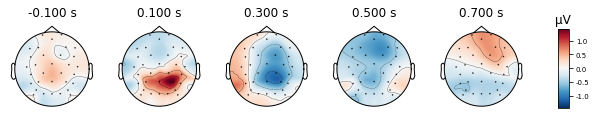

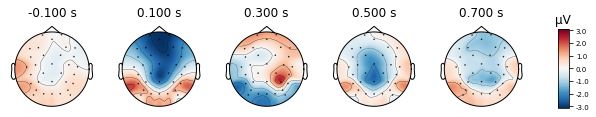

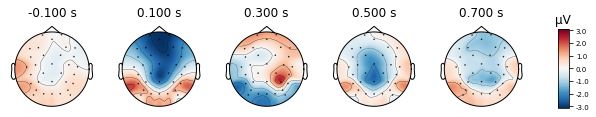

In [21]:
times = np.linspace(-0.1, 0.7, 5)
evoked_non.plot_topomap(ch_type='eeg', times=times, colorbar=True)
evoked_target.plot_topomap(ch_type='eeg', times = times, colorbar= True)

#### Plotting ERP together with topographies

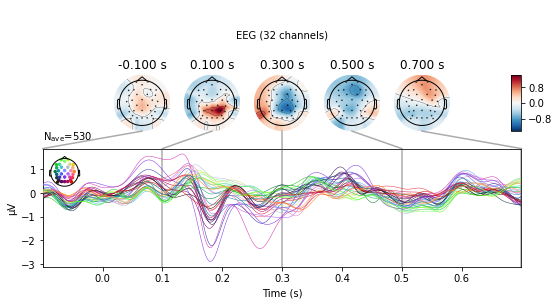

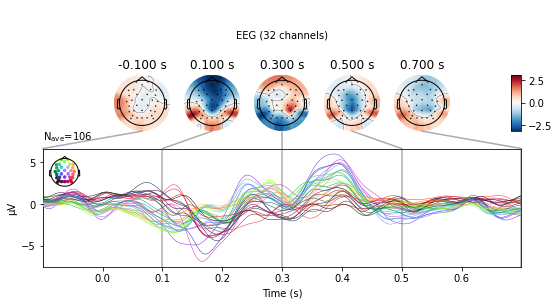

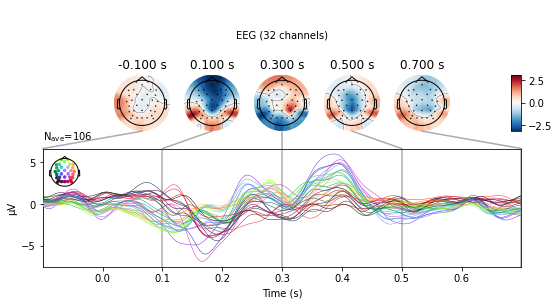

In [22]:
evoked_non.plot_joint(times=times)
evoked_target.plot_joint(times=times)

#### Image Plots

Not setting metadata
Not setting metadata
530 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


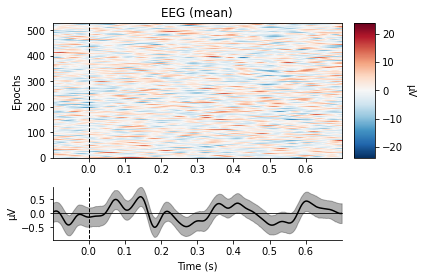

Not setting metadata
Not setting metadata
106 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


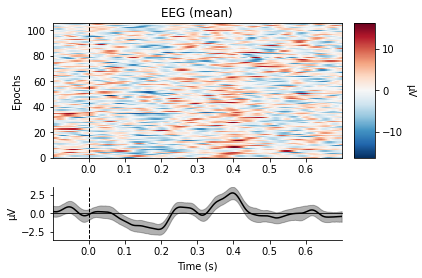

[<Figure size 432x288 with 3 Axes>]

In [23]:
epochs['Non-Target'].plot_image(picks='eeg', combine='mean')
epochs['Target'].plot_image(picks='eeg', combine='mean')

##### Comparing Evoked objects

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


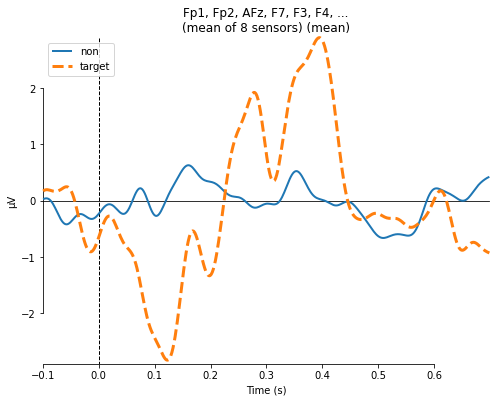

More than 6 channels, truncating title ...
combining channels using "median"
combining channels using "median"


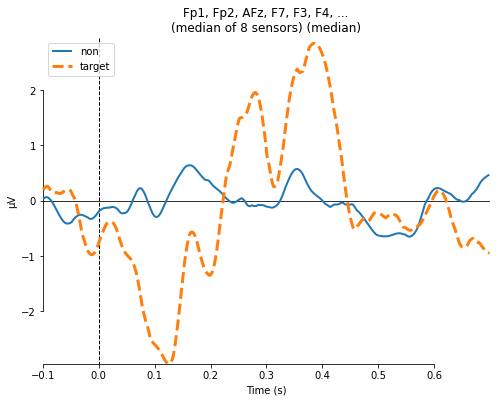

combining channels using "gfp"
combining channels using "gfp"


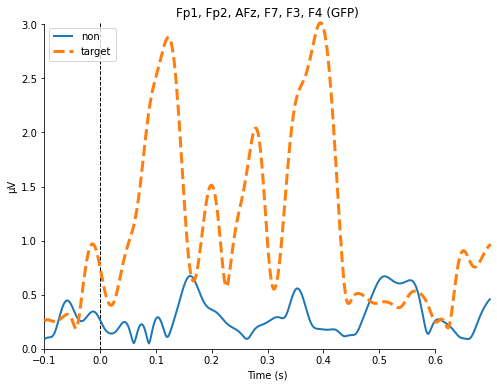

More than 6 channels, truncating title ...
combining channels using "<function custom_func at 0x7f5ec8a16dc0>"
combining channels using "<function custom_func at 0x7f5ec8a16dc0>"


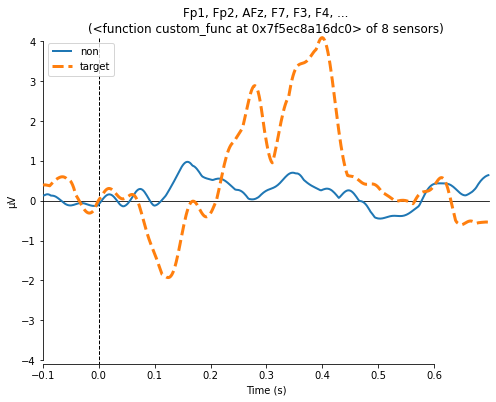

In [24]:
def custom_func(x):
    return x.max(axis=1)

total_evoked = {"non": evoked_non, "target": evoked_target}
for combine in ('mean', 'median', 'gfp', custom_func):
    mne.viz.plot_compare_evokeds(total_evoked, picks=[0,1,2,3,4,5,6,7], combine=combine,
                                colors=dict(non=0, target=1),
                                linestyles=dict(non='solid', target='dashed'),
                                 styles=dict(non=dict(linewidth=2),target=dict(linewidth=3)))

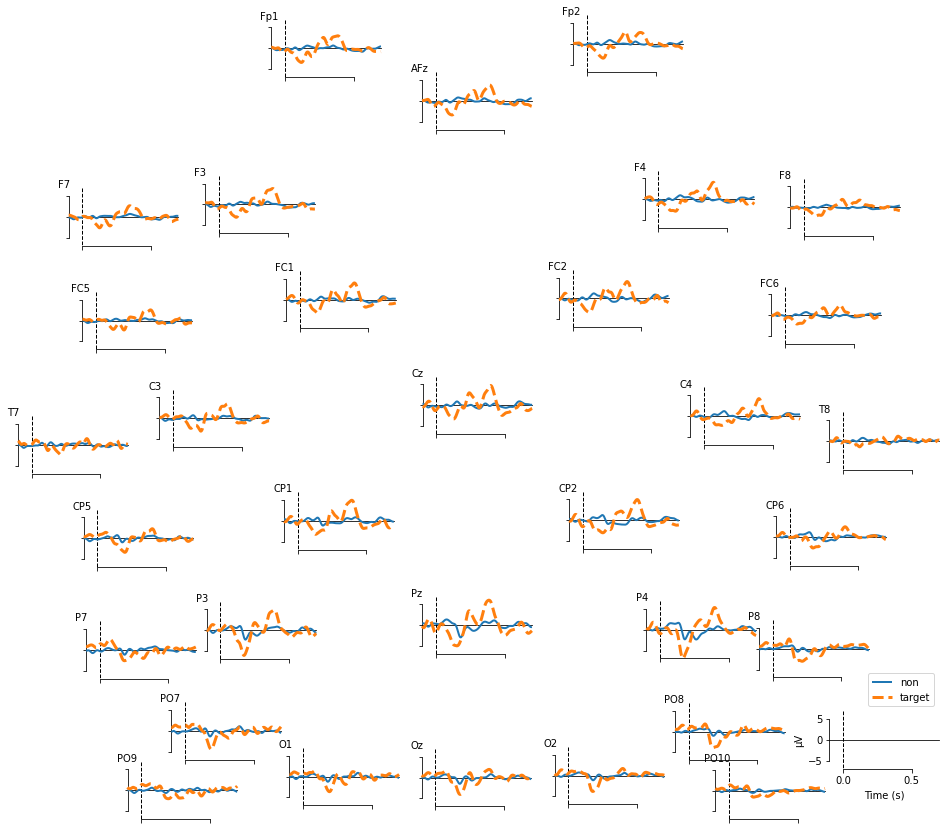

[<Figure size 1296x1008 with 33 Axes>]

In [25]:
mne.viz.plot_compare_evokeds(total_evoked, picks='eeg',
                                colors=dict(non=0, target=1), axes='topo',
                                linestyles=dict(non='solid', target='dashed'),
                            styles=dict(non=dict(linewidth=2),target=dict(linewidth=3)))

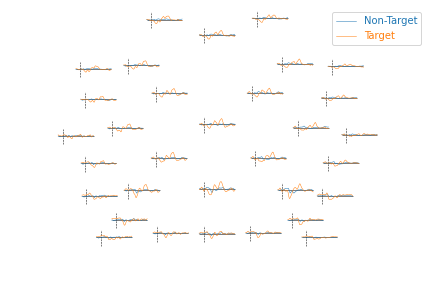

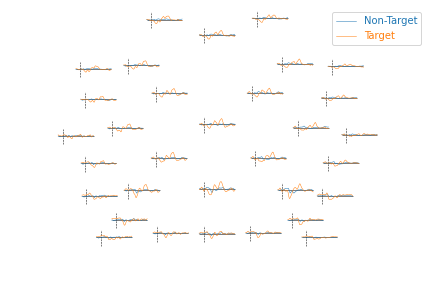

In [26]:
evokeds = [epochs[name].average() for name in ('Non-Target', 'Target')]
mne.viz.plot_evoked_topo(evokeds, layout_scale=1)

### Define LSTM Model

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [28]:
class LSTM(nn.Module):
    
    #Input Shape: (batch, seq_len, channels)
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional=bidirectional, 
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_layers, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Set initial hidden and cell states
        #*2 because it's bidirectional
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device).float()
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device).float()
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :]) 
        out = self.softmax(out)

        return out

In [29]:
input_dim = 32
hidden_dim = 32
num_layers = 2
num_classes = 4 
bidirectional = True
dropout = 0.5

model_lstm = LSTM(input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout)
model_lstm = model_lstm.float() #define precision as float to reduce running time


In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model {type(model_lstm).__name__} has {count_parameters(model_lstm):,} trainable parameters')# Train the model

The model LSTM has 42,244 trainable parameters


In [31]:
import torch.optim as optim

learning_rate = 0.01

optimizer = optim.Adam(model_lstm.parameters())
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)


Configured device:  cuda


In [33]:
#for model in models:
model_lstm = model_lstm.to(device)
criterion = criterion.to(device)

In [34]:
torch_X = torch.from_numpy(X)
torch_y = torch.from_numpy(y)

In [35]:
print("Original X: ", torch_X.size())

Original X:  torch.Size([636, 32, 410])


In [36]:
torch_X_reshaped = torch_X.permute(0, 2, 1)
print("Converted X: ", torch_X_reshaped.size())

Converted X:  torch.Size([636, 410, 32])


In [37]:
print("Original y: ", torch_y.size())

Original y:  torch.Size([636])


In [38]:
from torch.utils.data import TensorDataset

# Define dataset
ds = TensorDataset(torch_X_reshaped, torch_y)

#Train test split
train_size = int(torch_X_reshaped.size()[0] * 0.7)
valid_size = torch_X_reshaped.size()[0] - train_size
#test_size = int(torch_X_reshaped.size()[0] * 0.25)

print(train_size)
print(valid_size)
#print(test_size)

train_set, valid_set = torch.utils.data.random_split(ds, [train_size, valid_size])

BATCH_SIZE = 64 #keeping it binary so it fits GPU
#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

#Test set loader
#test_iterator = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE, 
                                          #shuffle=True)

445
191


In [39]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []
    trues = []
    
    #model.eval()
    
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        predicteds.append(predicted)
        trues.append(labels)
        total += labels.size(0)  #keep track of total
        correct += (predicted == labels).sum().item()  #.item() give the raw number
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
   # return epoch_loss / len(iterator), epoch_acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator),predicteds, trues

In [40]:
def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
     
    predicteds = []
    trues = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            predicteds.append(predicted)
            trues.append(labels)
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
   # return epoch_loss / len(iterator), epoch_acc / len(iterator)

        
    return epoch_loss / len(iterator), epoch_acc / len(iterator),predicteds, trues

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [42]:
N_EPOCHS = 20

best_valid_loss = float('inf')


train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

train_predicted_labels = []
valid_predicted_labels = []

train_true_labels = []
valid_true_labels = []


#for i, model in enumerate(models):
print(f"Training {type(model_lstm).__name__}")

start_time = time.time()

for epoch in range(N_EPOCHS):
    start_time = time.time()

    #train_loss, train_acc = train(model_lstm, train_iterator, optimizer, criterion)
   # valid_loss, valid_acc = evaluate(model_lstm, valid_iterator, criterion)
    
    train_loss, train_acc, train_pred_label, train_true_label = train(model_lstm, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_pred_label, valid_true_label= evaluate(model_lstm, valid_iterator, criterion)
    
    train_losses.append(train_loss); train_accs.append(train_acc); train_predicted_labels.append(train_pred_label); train_true_labels.append(train_true_label)
    valid_losses.append(valid_loss); valid_accs.append(valid_acc); valid_predicted_labels.append(valid_pred_label); valid_true_labels.append(valid_true_label)


    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch+1) % 5 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Model:{} saved.".format(type(model_lstm).__name__))
        #torch.save(model.state_dict(), 'models/checkpoint.pth.tar')
        #best_model_index = i

Training LSTM
Model:LSTM saved.
Model:LSTM saved.
Model:LSTM saved.
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.463 | Train Acc: 11.85%
	 Val. Loss: 0.436 |  Val. Acc: 86.69%
Model:LSTM saved.
Model:LSTM saved.
Model:LSTM saved.
Model:LSTM saved.
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.460 | Train Acc: 11.85%
	 Val. Loss: 0.437 |  Val. Acc: 86.69%
Epoch: 15 | Epoch Time: 0m 0s
	Train Loss: 0.465 | Train Acc: 11.85%
	 Val. Loss: 0.435 |  Val. Acc: 80.96%
Model:LSTM saved.
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.458 | Train Acc: 11.85%
	 Val. Loss: 0.435 |  Val. Acc: 84.61%


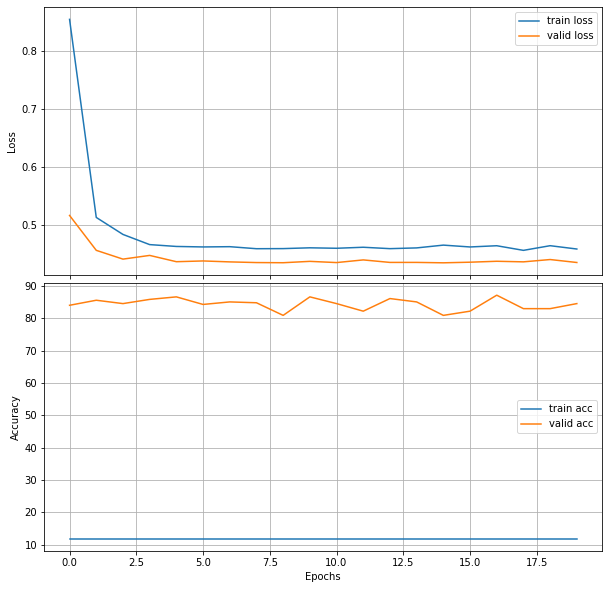

In [43]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].plot(np.arange(N_EPOCHS),train_losses,label = "train loss")
ax[0].plot(np.arange(N_EPOCHS),valid_losses, label = "valid loss")
ax[1].plot(np.arange(N_EPOCHS),train_accs,label = "train acc")
ax[1].plot(np.arange(N_EPOCHS),valid_accs,label = "valid acc")

plt.subplots_adjust(hspace=0.03)
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
plt.show()